# Compare CESM2 historic conditions in line with ERA5

- Calculates spatial mean over full domain (removing land points) between 80S to 58S
- On the original ERA5 and CESM2 grids, grid cells not area-weighted (for simplicity, obviously not exactly correct)
- Annual means (easy to regrid to other frequencies)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
from dateutil.relativedelta import relativedelta
import datetime
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file
from nemo_python_git.atm_calc import wind_curl, wind_divergence

In [2]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/'
era5_dir  = f'{base_dir}ERA5-forcing/'

In [3]:
ens_strs = ['1011.001', '1031.002', '1051.003', '1071.004', '1091.005', '1111.006', '1131.007', '1151.008', '1171.009', '1191.010']
var_mapping = {'TREFHT':'t2m','FSDS':'msdwswrf','FLDS':'msdwlwrf','QREFHT':'sph2m', 'PRECS':'msr', 'PRECT':'mtpr', 'PSL':'msl', 'wind_speed':'wind_speed'}
#FLDS 1031, 1091, 1151 have some weird daily values; check if that is also true for some of the other files and why

In [4]:
mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze().isel(nav_lev=0)

In [42]:
dsu_raw = xr.open_dataset(f'{cesm2_dir}processed_highres/ens1011.001/CESM2-LE2_ens1011.001_eANT025_3-hourly_UBOT_y1978m01.nc')
dsv_raw = xr.open_dataset(f'{cesm2_dir}processed_highres/ens1011.001/CESM2-LE2_ens1011.001_eANT025_3-hourly_VBOT_y1978m01.nc')
dsu = xr.open_dataset(f'{cesm2_dir}bias-corrected/ens1011.001/test3/CESM2-LE2_ens1011.001_eANT025_3-hourly_UBOT_bias_corr_monthly_2D_y1978m01.nc')
dsv = xr.open_dataset(f'{cesm2_dir}bias-corrected/ens1011.001/test3/CESM2-LE2_ens1011.001_eANT025_3-hourly_UBOT_bias_corr_monthly_2D_y1978m01.nc')

In [37]:
angle_bias = xr.open_dataset(f'{cesm2_dir}ensemble_mean/bias_corr/CESM2-LE2_wind_angle_3-hourly_bias_corr_monthly.nc')
speed_bias = xr.open_dataset(f'{cesm2_dir}ensemble_mean/bias_corr/CESM2-LE2_wind_speed_3-hourly_bias_corr_monthly.nc')

angle_raw = np.arctan2(dsv_raw.VBOT, dsu_raw.UBOT).rename('wind_angle')
speed_raw = np.hypot(dsu_raw.UBOT, dsv_raw.VBOT).rename('wind_speed')

angle_corrected = angle_raw.isel(time_counter=(angle_raw.time_counter.dt.month==1)) + angle_bias.isel(month=0)

dsu_corrected = np.cos(angle_corrected.wind_angle)*speed_raw.isel(time_counter=(angle_raw.time_counter.dt.month==1))*speed_bias.wind_speed.isel(month=0).rename('UBOT')
dsv_corrected = np.sin(angle_corrected.wind_angle)*speed_raw.isel(time_counter=(angle_raw.time_counter.dt.month==1))*speed_bias.wind_speed.isel(month=0).rename('VBOT')

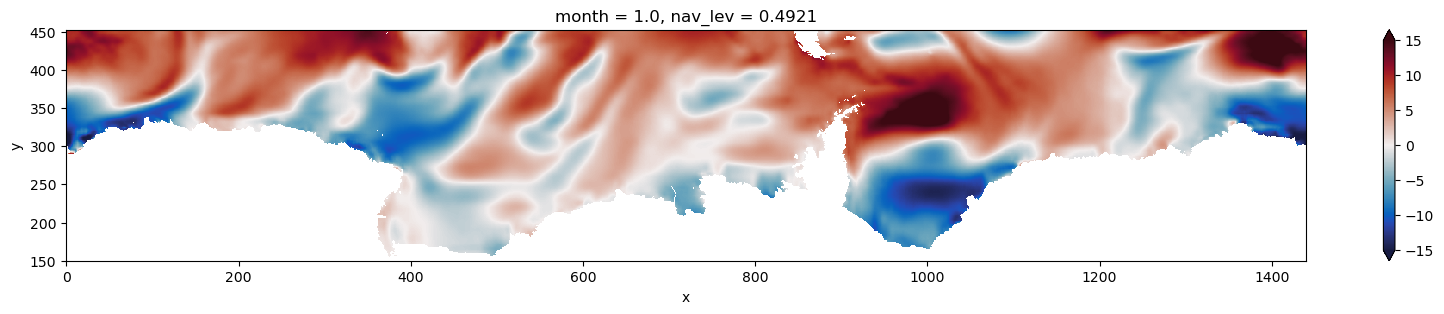

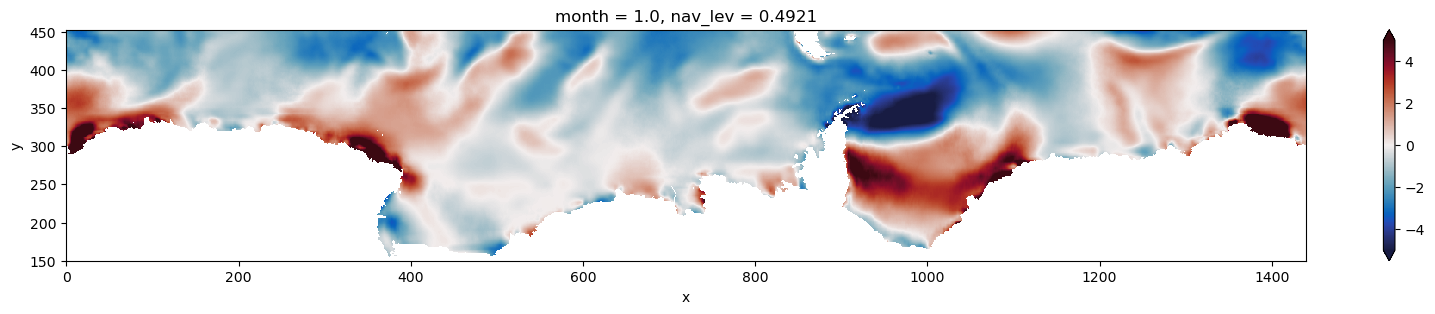

In [38]:
dsu_corrected.isel(time_counter=0).where(mesh_mask.tmask!=0).plot(vmin=-15, vmax=15, cmap=cmocean.cm.balance, figsize=(20,3), ylim=(150,None))
(dsu_corrected-dsu_raw.UBOT).isel(time_counter=0).where(mesh_mask.tmask!=0).plot(vmin=-5, vmax=5, cmap=cmocean.cm.balance, figsize=(20,3), ylim=(150,None))

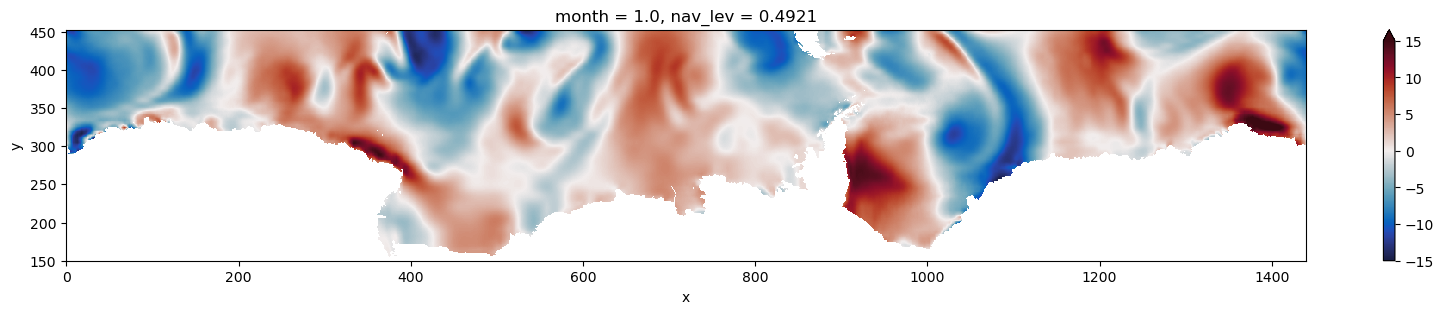

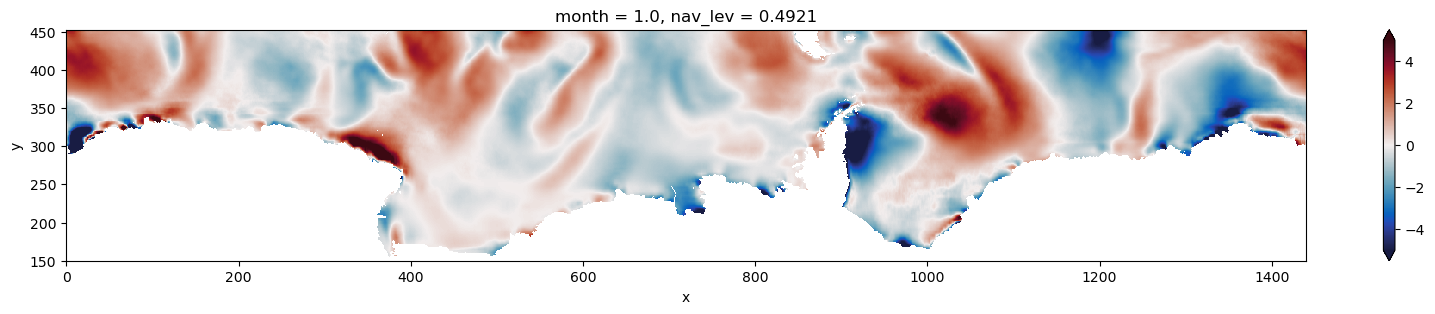

In [40]:
dsv_corrected.isel(time_counter=0).where(mesh_mask.tmask!=0).plot(vmin=-15, vmax=15, cmap=cmocean.cm.balance, figsize=(20,3), ylim=(150,None))
(dsv_corrected-dsv_raw.VBOT).isel(time_counter=0).where(mesh_mask.tmask!=0).plot(vmin=-5, vmax=5, cmap=cmocean.cm.balance, figsize=(20,3), ylim=(150,None))

## Bias correction

In [255]:
bias_corr_u = xr.open_dataset(f'{cesm2_dir}ensemble_mean/bias_corr/CESM2-LE2_UBOT_3-hourly_bias_corr_monthly.nc')#.where(mesh_mask.tmask!=0)
bias_corr_v = xr.open_dataset(f'{cesm2_dir}ensemble_mean/bias_corr/CESM2-LE2_VBOT_3-hourly_bias_corr_monthly.nc')#.where(mesh_mask.tmask!=0)
cesm2_u = xr.open_dataset(f'{cesm2_dir}ensemble_mean/CESM2-LE2_eANT025_UBOT_3-hourly_ensemble_1979-2024_mean_monthly.nc').UBOT.where(mesh_mask.tmask!=0)
cesm2_v = xr.open_dataset(f'{cesm2_dir}ensemble_mean/CESM2-LE2_eANT025_VBOT_3-hourly_ensemble_1979-2024_mean_monthly.nc').VBOT.where(mesh_mask.tmask!=0)
era5_u  = xr.open_dataset(f'{era5_dir}climatology/ERA5_eANT025_u10_3-hourly_1979-2024_mean_monthly.nc').u10.where(mesh_mask.tmask!=0)
era5_v  = xr.open_dataset(f'{era5_dir}climatology/ERA5_eANT025_v10_3-hourly_1979-2024_mean_monthly.nc').v10.where(mesh_mask.tmask!=0)

In [256]:
bias_lim = 0.1
gradient_x = bias_corr_u.UBOT.differentiate('x')
gradient_y = bias_corr_u.UBOT.differentiate('y')
new_corr_u1 = xr.where(np.abs(gradient_x+gradient_y) > bias_lim, np.nan, bias_corr_u)

bias_lim = 2
new_corr_u2 = xr.where(np.abs(bias_corr_u) > bias_lim, np.nan, bias_corr_u)

In [258]:
filled = fill_nan_griddata(new_corr_u1.UBOT.isel(month=0).values, method="cubic")

In [259]:
new_corr_u3 = new_corr_u1.isel(month=0).copy()
new_corr_u3['UBOT'] = (('y','x'), filled)

In [275]:
bias_lim = 1
new_corr_u2 = xr.where(np.abs(bias_corr_u) > bias_lim, np.nan, bias_corr_u)
new_corr_u3 = xr.where(np.abs(bias_corr_u) > bias_lim, bias_corr_u*0.5, bias_corr_u)
da_filled = new_corr_u2.UBOT.interpolate_na(dim='y', method='spline', order=3).where(mesh_mask.tmask!=0)

In [293]:
import scipy.ndimage as nd

def smooth_gaussian(da, sigma=1):
    return xr.apply_ufunc(
        nd.gaussian_filter,
        da,
        kwargs={'sigma': sigma},
        dask='parallelized',
        output_dtypes=[da.dtype],
    )

da_smoothed = smooth_gaussian(da_filled, sigma=2)

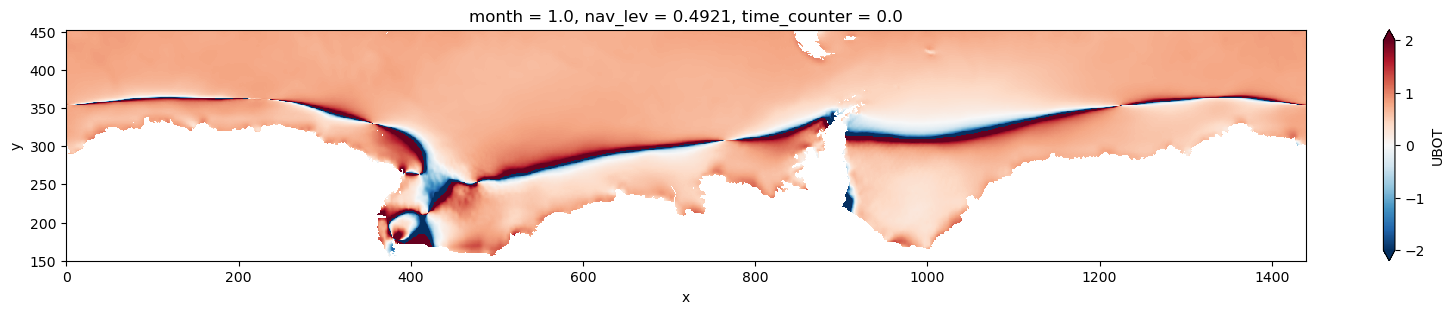

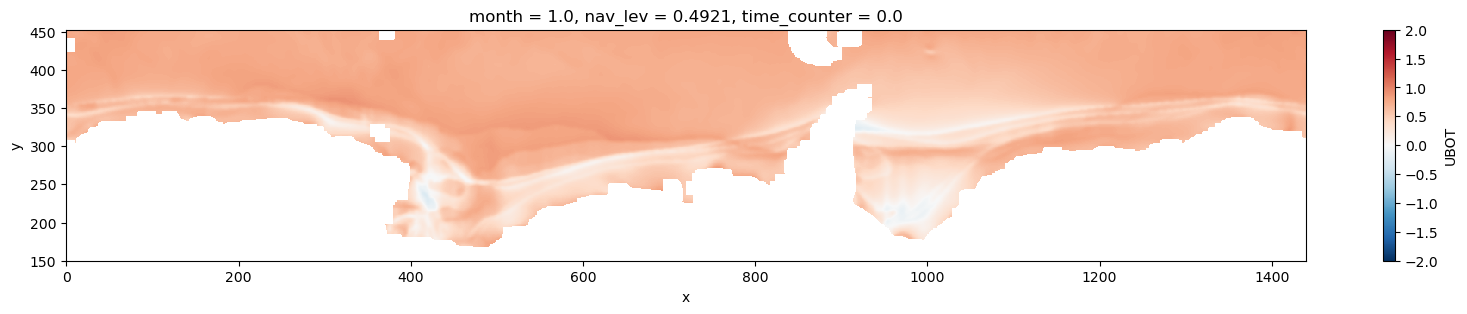

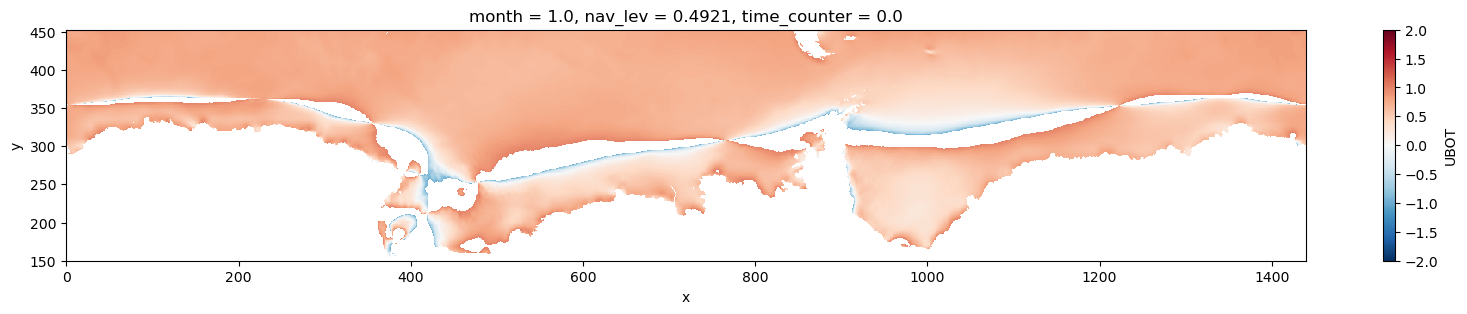

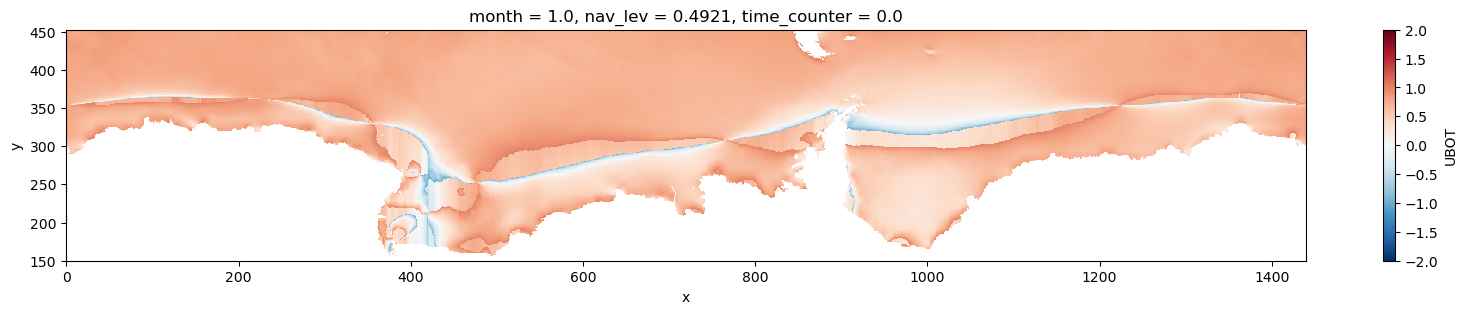

In [294]:
bias_lim = 1
mth = 0
new_corr_u2 = xr.where(np.abs(bias_corr_u) > bias_lim, np.nan, bias_corr_u)
bias_corr_u.UBOT.isel(month=mth).where(mesh_mask.tmask!=0).plot(vmin=-2,vmax=2, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
da_smoothed.isel(month=mth).where(mesh_mask.tmask!=0).plot(vmin=-2,vmax=2, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
new_corr_u2.UBOT.isel(month=mth).where(mesh_mask.tmask!=0).plot(vmin=-2,vmax=2, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
da_filled.isel(month=mth).where(mesh_mask.tmask!=0).plot(vmin=-2,vmax=2, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

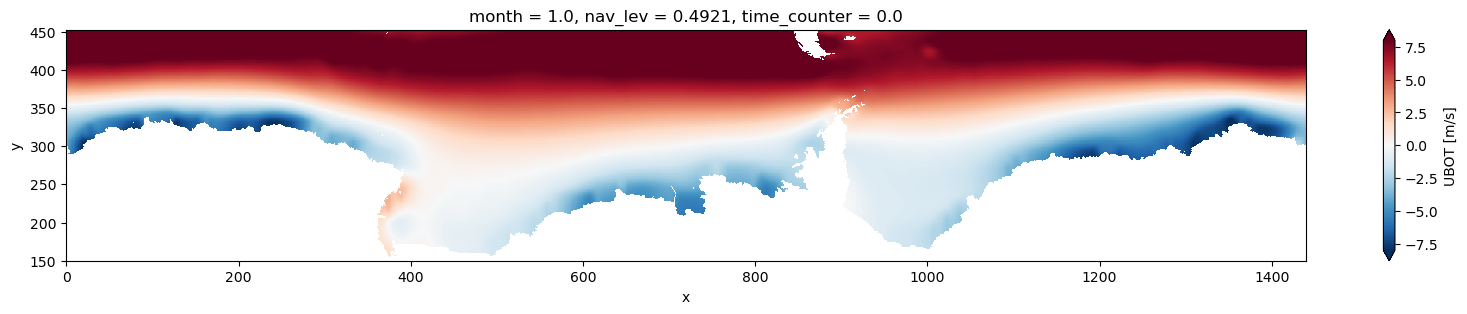

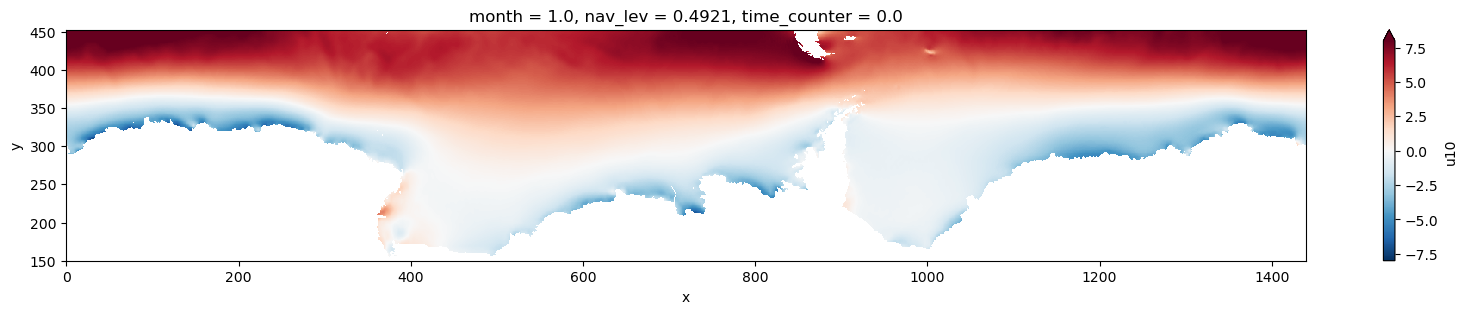

In [266]:
vlim=2
bias_lim = 2
mth = 0
new_corr_u = xr.where(np.abs(bias_corr_u) > bias_lim, np.sign(bias_corr_u)*bias_lim, bias_corr_u)

cesm2_u.isel(month=mth).plot(vmin=-8,vmax=8, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
era5_u.isel(month=mth).plot(vmin=-8,vmax=8, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
new_corr_u.isel(month=mth).plot(vmin=-vlim,vmax=vlim, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
(cesm2_u.isel(month=mth)*new_corr_u.isel(month=mth)).plot(vmin=-8, vmax=8, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))

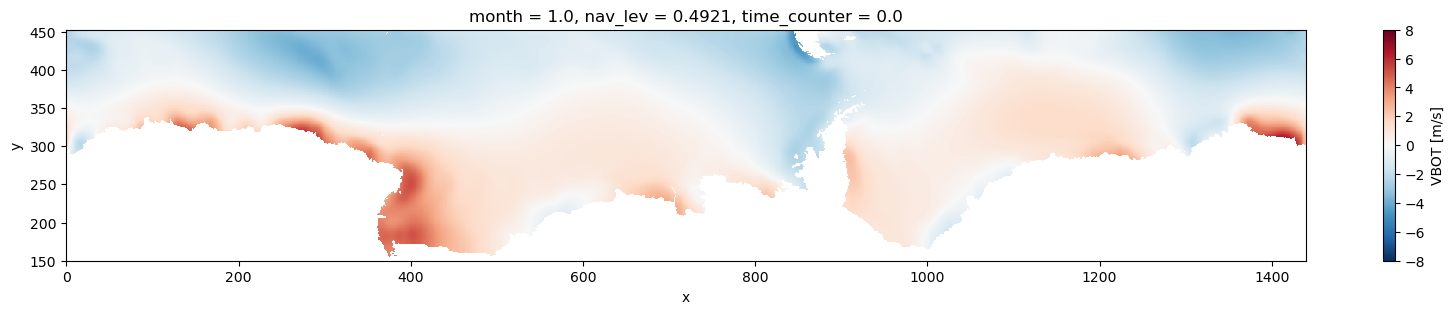

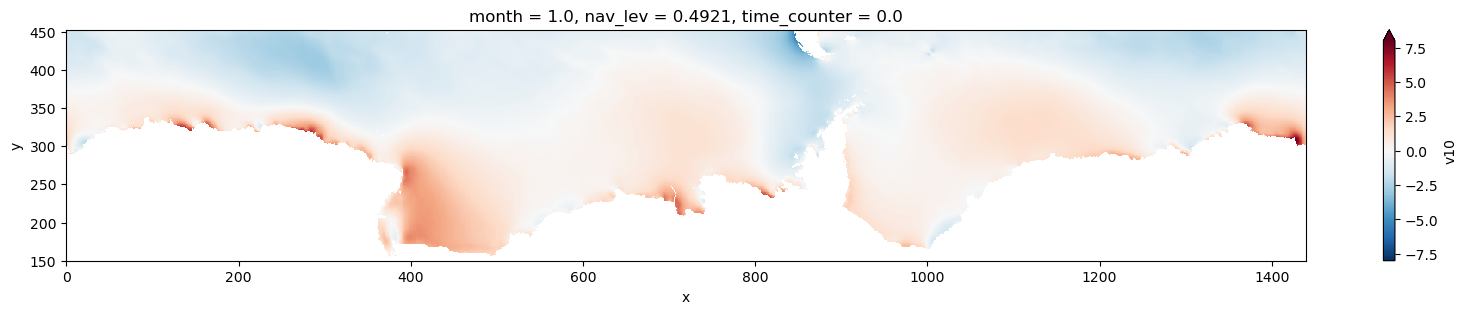

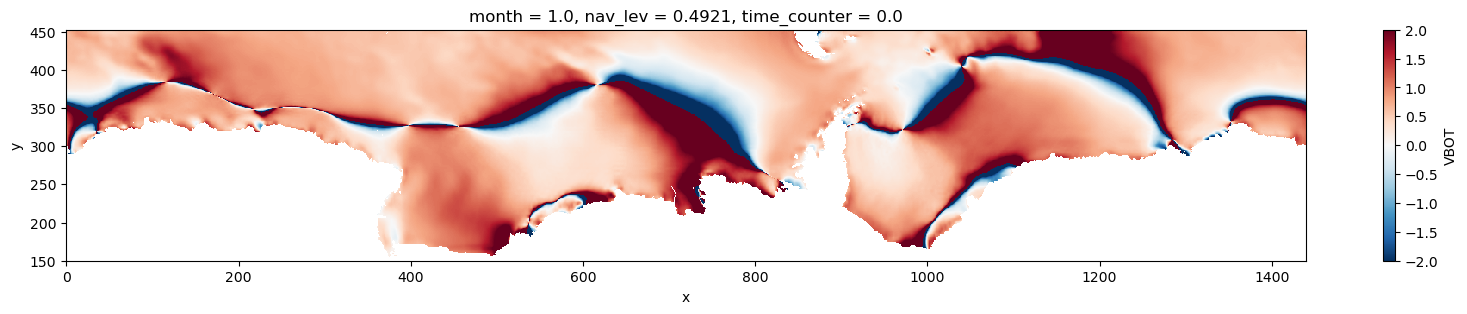

In [35]:
vlim=2
bias_lim = 2
mth = 0
new_corr_v = xr.where(np.abs(bias_corr_v) > bias_lim, np.sign(bias_corr_v)*bias_lim, bias_corr_v)

cesm2_v.isel(month=mth).plot(vmin=-8,vmax=8, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
era5_v.isel(month=mth).plot(vmin=-8,vmax=8, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))
new_corr_v.isel(month=mth).plot(vmin=-vlim,vmax=vlim, cmap="RdBu_r", figsize=(20,3), ylim=(150,None))

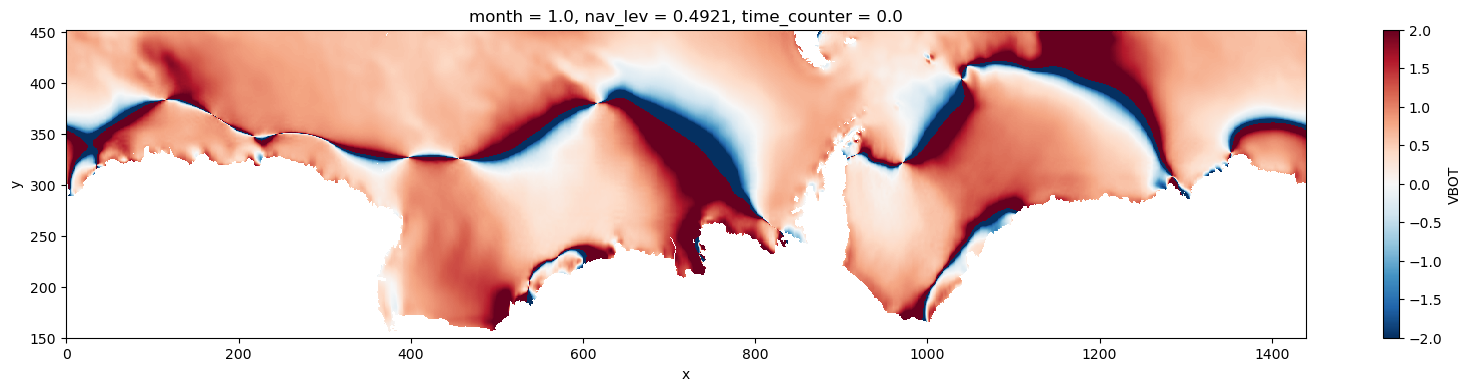

In [33]:
vlim=2
bias_lim = 2
mth = 0
new_corr_u = xr.where(np.abs(bias_corr_u) > bias_lim, np.sign(bias_corr_u)*bias_lim, bias_corr_u)
new_corr_v = xr.where(np.abs(bias_corr_v) > bias_lim, np.sign(bias_corr_v)*bias_lim, bias_corr_v)
# new_corr_u.isel(month=mth).plot(vmin=-vlim,vmax=vlim, cmap="RdBu_r", figsize=(20,4), ylim=(150,None))
new_corr_v.isel(month=mth).plot(vmin=-vlim,vmax=vlim, cmap="RdBu_r", figsize=(20,4), ylim=(150,None))

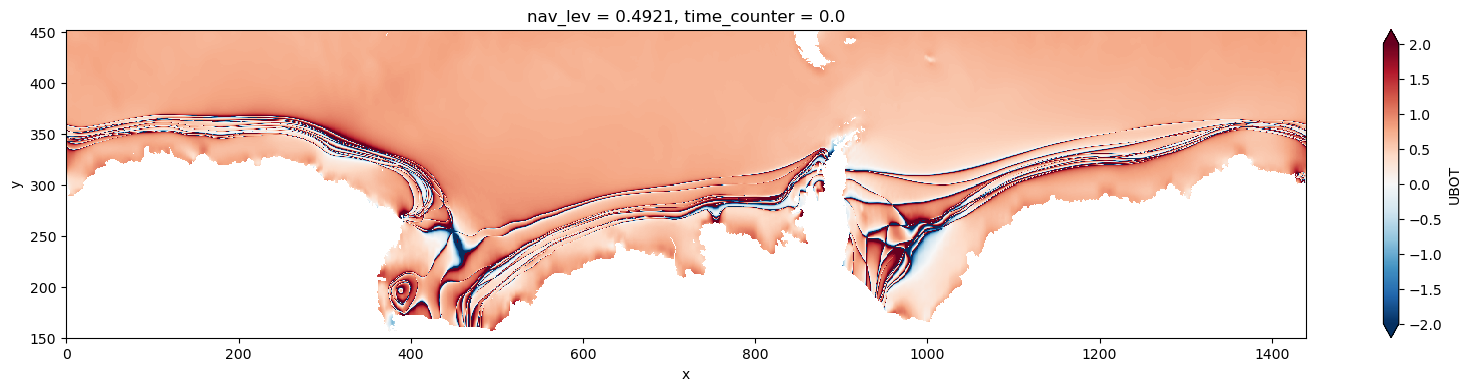

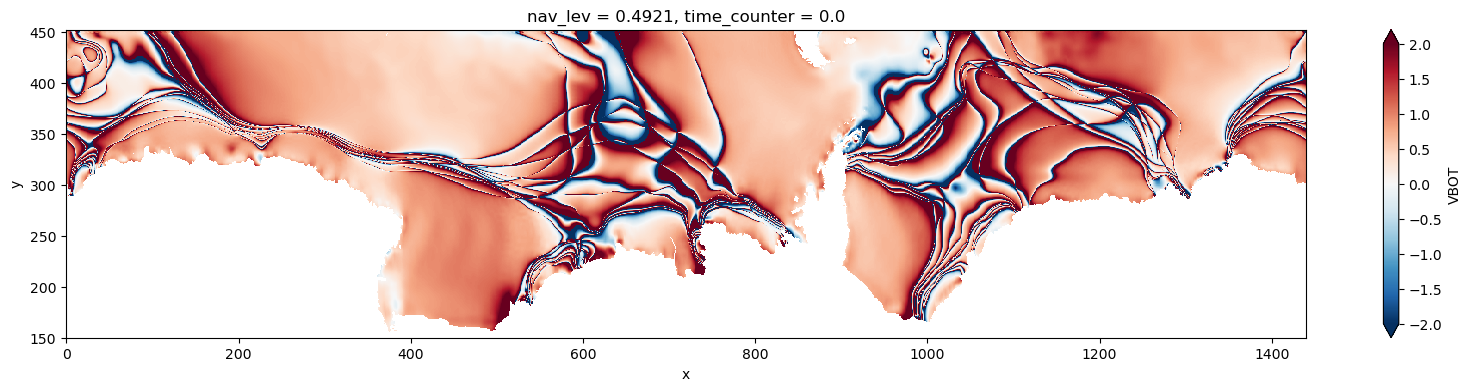

In [23]:
vlim=2
bias_corr_u.mean(dim='month').plot(vmin=-vlim,vmax=vlim, cmap="RdBu_r", figsize=(20,4), ylim=(150,None))
bias_corr_v.mean(dim='month').plot(vmin=-vlim,vmax=vlim, cmap="RdBu_r", figsize=(20,4), ylim=(150,None))

## Wind deep dive!

In [5]:
def plot_atm_var(da, year, mask, vmin=None, vmax=None):
    
    fig, ax = plt.subplots(4,3, figsize=(20,15))

    # each panel is a month
    for a, axis in enumerate(ax.ravel()):
        da.isel(month=a).where(mask).plot(ax=axis, cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax)    
        axis.set_title(f'y{year}m{(a+1):02}')
    
        axis.set_xlabel(''); axis.set_ylabel('');
    return

In [54]:
uwind = xr.open_dataset(f'{era5_dir}hourly/processed/u10_y1979.nc').u10.sel(lat=slice(-50,-80))
vwind = xr.open_dataset(f'{era5_dir}hourly/processed/v10_y1979.nc').v10.sel(lat=slice(-50,-80))

era5_mask = xr.open_dataset(f'{era5_dir}climatology/land_sea_mask.nc').isel(time=0).rename({'longitude':'lon','latitude':'lat'})
era5_mask['lon'] = fix_lon_range(era5_mask['lon'])
era5_mask = era5_mask.sortby('lon').isel(lat=slice(None, None, -1)).sel(lat=slice(-80,-50))

In [55]:
ts_zeta = None
ts_div  = None
for month in range(1,13):
    print(month)
    zeta = wind_curl(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
    div = wind_divergence(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
    zeta_mean = zeta.mean(dim='time')
    div_mean = div.mean(dim='time')

    if ts_zeta is None:
        ts_zeta = zeta_mean
        ts_div  = div_mean
    else:
        ts_zeta = xr.concat([ts_zeta, zeta_mean], dim="month")
        ts_div  = xr.concat([ts_div, div_mean], dim="month")

1
2
3
4
5
6
7
8
9
10
11
12


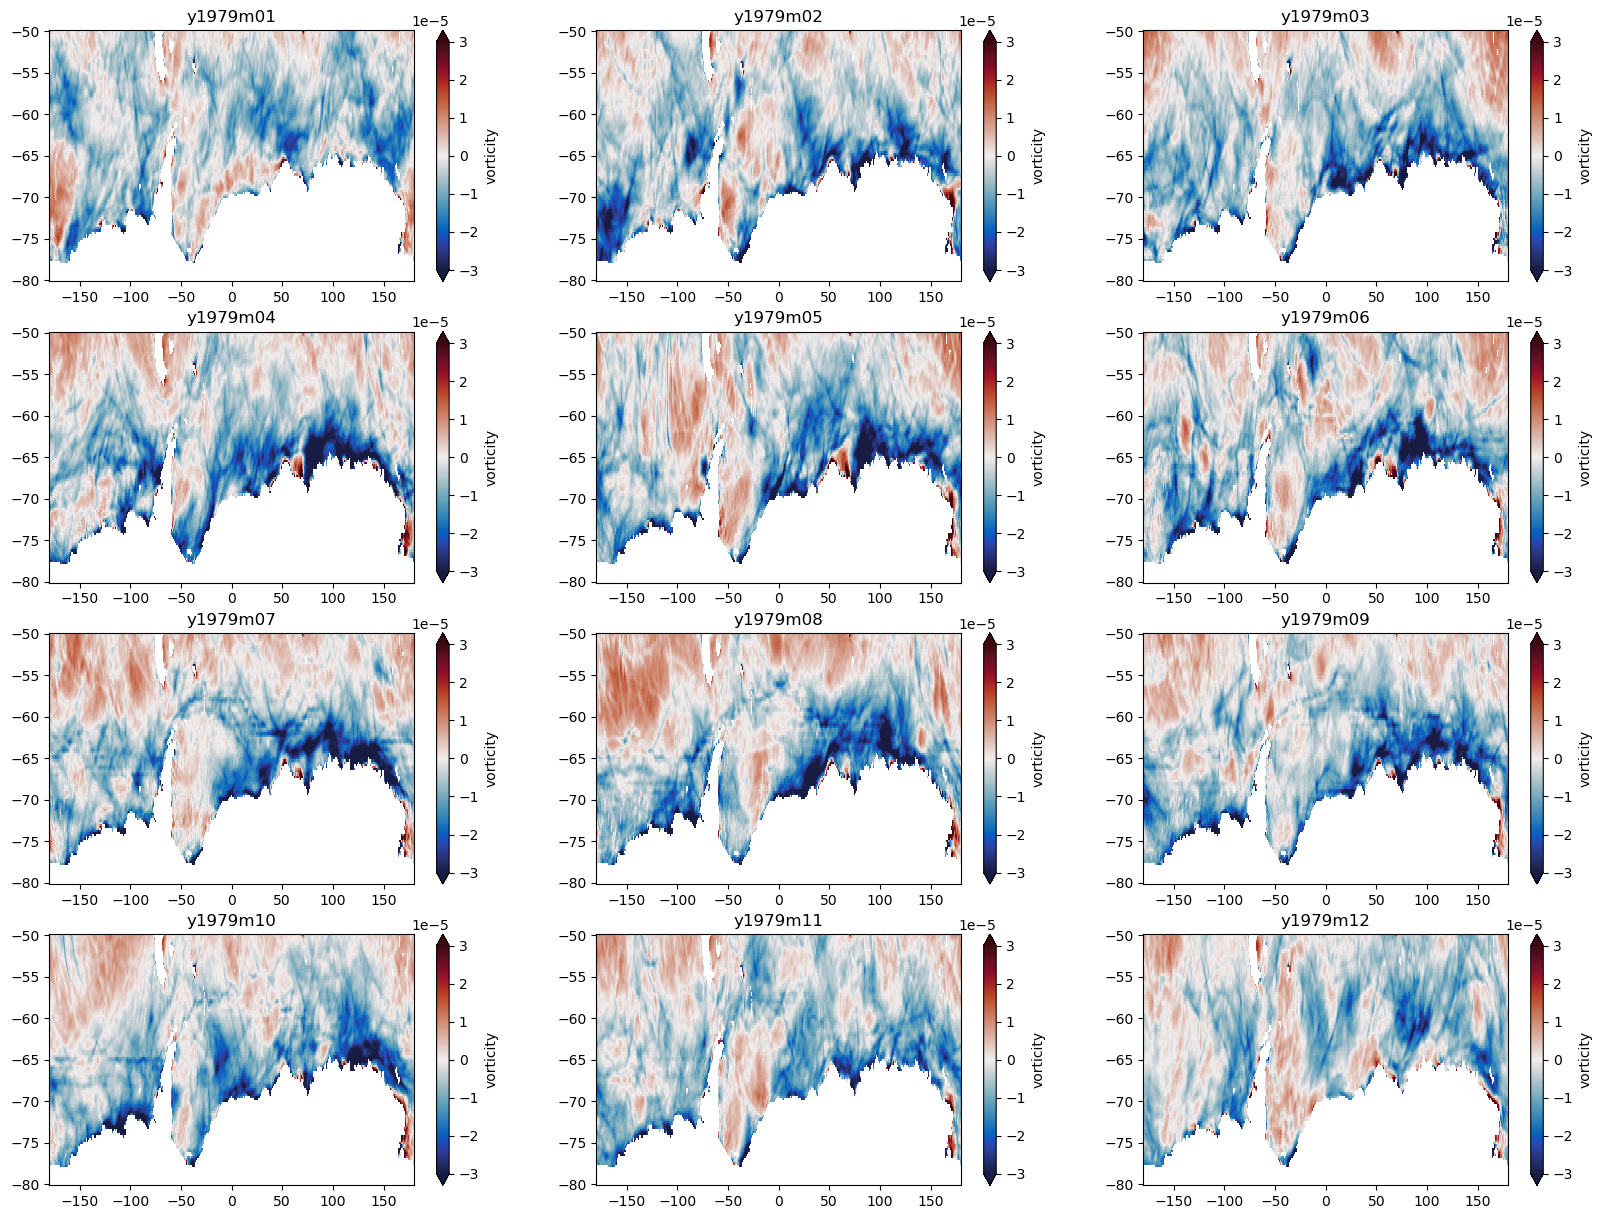

In [35]:
plot_atm_var(ts_zeta, 1979, (era5_mask.lsm==0), vmin=-3e-5, vmax=3e-5)

In [5]:
uwind = xr.open_dataset(f'{cesm2_dir}processed/ens1011.001/CESM2-LE2_ens1011.001_3-hourly_UBOT_y1979.nc').UBOT.sel(lat=slice(-80,-50)).sortby('lon')
vwind = xr.open_dataset(f'{cesm2_dir}processed/ens1011.001/CESM2-LE2_ens1011.001_3-hourly_VBOT_y1979.nc').VBOT.sel(lat=slice(-80,-50)).sortby('lon')

land_mask  = find_cesm2_file('LE2', 'LANDFRAC', 'atm', 'monthly', '1011.001', 1979)
cesm2_mask = xr.open_dataset(land_mask).LANDFRAC.isel(time=0)
cesm2_mask['lon'] = fix_lon_range(cesm2_mask['lon'])
cesm2_mask = cesm2_mask.sortby('lon','lat').sel(lat=slice(-80,-50))

In [ ]:
ts_zeta_cesm2 = None
for month in range(1,13):
    zeta = curl_spherical(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
    zeta_mean = zeta.mean(dim='time')

    if ts_zeta_cesm2 is None:
        ts_zeta_cesm2 = zeta_mean
    else:
        ts_zeta_cesm2 = xr.concat([ts_zeta_cesm2, zeta_mean], dim="month")

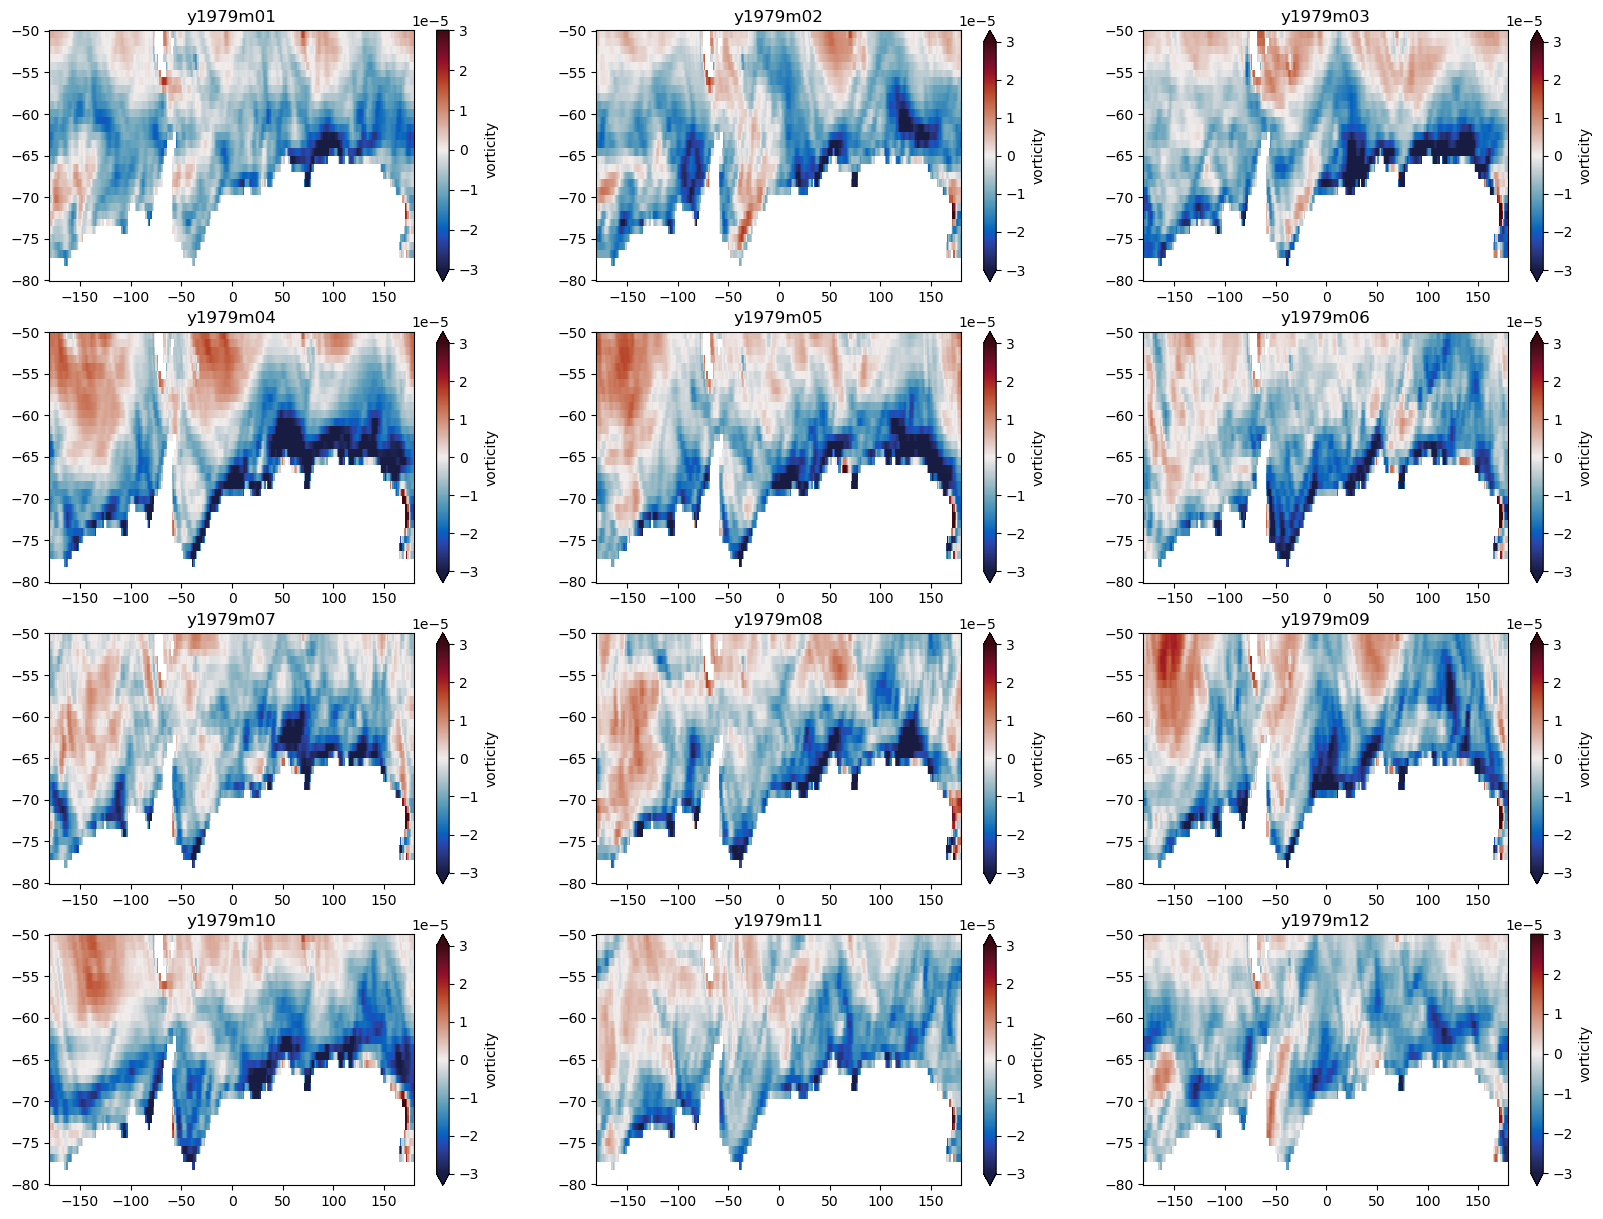

In [46]:
plot_atm_var(ts_zeta_cesm2, 1979, (cesm2_mask==0), vmin=-3e-5, vmax=3e-5)

In [6]:
from tqdm import tqdm

In [ ]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/'
latslice  = slice(-90,-50)
# ens='1051.003'

# ens_strs = ['1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010'] + \
#             [f'1231.0{i:02}' for i in range(11,16)] + [f'1251.0{i:02}' for i in range(11,16)] + [f'1281.0{i:02}' for i in range(11,16)] + \
#             [f'1301.0{i:02}' for i in range(11,16)]
ens_strs =  [f'1251.0{i:02}' for i in range(12,16)] + [f'1281.0{i:02}' for i in range(11,16)] + \
            [f'1301.0{i:02}' for i in range(11,16)]

for ens in ens_strs:
    ds_curl_ts = None
    ds_div_ts  = None
    print(ens)
    for year in tqdm(range(1979,2025)):
        uwind = xr.open_dataset(f'{cesm2_dir}processed/ens{ens}/CESM2-LE2_ens{ens}_3-hourly_UBOT_y{year}.nc').UBOT.sel(lat=latslice).sortby('lon')
        vwind = xr.open_dataset(f'{cesm2_dir}processed/ens{ens}/CESM2-LE2_ens{ens}_3-hourly_VBOT_y{year}.nc').VBOT.sel(lat=latslice).sortby('lon')
    
        for month in range(1,13):
            zeta      = wind_curl(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
            zeta_mean = zeta.mean(dim='time')
            div       = wind_divergence(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
            div_mean  = div.mean(dim='time')
    
            if ds_curl_ts is None:
                ds_curl_ts = zeta_mean
                ds_div_ts  = div_mean
            else:
                ds_curl_ts = xr.concat([ds_curl_ts, zeta_mean], dim="time")
                ds_div_ts  = xr.concat([ds_div_ts, div_mean], dim="time")
    
    ds_time = [datetime.datetime(1979, 1, 1) + relativedelta(months=dt) for dt in range(0,len(range(1979,2025))*12)]
    ds_curl_ts = ds_curl_ts.assign_coords({'time':ds_time})
    ds_div_ts  = ds_div_ts.assign_coords({'time':ds_time})
    
    ds_curl_ts.to_dataset().to_netcdf(f'{cesm2_dir}ensemble_mean/wind_curl_ens{ens}_1979-2024.nc')
    ds_div_ts.to_dataset().to_netcdf(f'{cesm2_dir}ensemble_mean/wind_divergence_ens{ens}_1979-2024.nc')

1251.012


  0%|          | 0/46 [00:00<?, ?it/s]

In [57]:
ensemble_curl = xr.Dataset()
ensemble_div  = xr.Dataset()
for ens in ens_strs:
    ds_curl = xr.open_dataset(f'{cesm2_dir}ensemble_mean/wind_curl_ens{ens}_1979-2024.nc')
    ds_div  = xr.open_dataset(f'{cesm2_dir}ensemble_mean/wind_divergence_ens{ens}_1979-2024.nc')

    ensemble_curl[f'{ens}'] = ds_curl.vorticity.groupby('time.month').mean()
    ensemble_div[f'{ens}']  = ds_div.divergence.groupby('time.month').mean()